# **Maestría en Inteligencia Artificial Aplicada**
## Proyecto Integrador (Gpo 26)
> ### Tecnológico de Monterrey
>### Avance 5 - **Modelo Final**


## -

## **Automatización del Registro de Materiales Médicos mediante Visión Computacional**

### *EQUIPO* 26


* ### Luis Fernando Rojas Marta - A00757351
* ### Jose Eduardo Carreon - A01372413


### **Carga e Instalacion de Librerias y Modelos:**
Ejecutar una sola vez

In [ ]:
# Instalacion de Librerias de YOLO y EasyOCR
!pip install ultralytics
!pip install easyocr

In [2]:
# Montaje de la Unidad de Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Importacion de las Librerias
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
from PIL import Image
import easyocr
from datetime import datetime

## **Funciones**

In [4]:
####################
'''
FUNCIONES y MODELO:
'''
####################

#### Carga del modelo
#model = YOLO("/content/drive/MyDrive/YOLOv8_resultados50EPOCH/train/weights/best.pt")                                # Direccion Eduardo
model = YOLO("/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/YOLOv8_resultados50EPOCH/train/weights/best.pt") # Direccion Fer


#### ##### RUTINA PRINCIPAL ######
def procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"], confianza_threshold=0.60):
    #IMAGEN: Cargar la imagen
    image = cv2.imread(ruta_imagen)

    #YOLO: Inferencia
    results = model(image)[0]

    #OCR: Inicializar lector OCR
    reader = easyocr.Reader(['en'])  #Agregar  'es' si se requiere para las Tags

    resultados = []

    for i in range(len(results.boxes)):
        conf = results.boxes.conf[i].item()
        if conf < confianza_threshold:         #Se revisa que la confianza de la inferencia sea mayor al Threshold (default= 60%)
            print(f"[Descartado] Corte #{i+1} - Confianza: {conf:.2f}")
            continue

        #RECORTE: Crop a imagen
        x1, y1, x2, y2 = map(int, results.boxes.xyxy[i].tolist())
        crop = image[y1:y2, x1:x2]

        #OCR para este crop
        ocr_result = reader.readtext(crop)
        textos = [res[1] for res in ocr_result]
        results_df = pd.DataFrame(textos, columns=["Text"])

        #EXTRACCION FECHAS si es necesario
        incluir_fab = "FABRICACION" in etiquetas
        incluir_cad = "CADUCIDAD" in etiquetas
        fab_fecha, cad_fecha = None, None
        if incluir_fab or incluir_cad:
            fab_fecha, cad_fecha = extraer_fechas(results_df)

        #EXTRACCION TAGS OCR reales
        etiquetas_ocr = [et for et in etiquetas if et not in ["FABRICACION", "CADUCIDAD"]]
        valores = extraer_valores_por_tag(results_df, etiquetas_ocr)

        if incluir_fab:
            valores["FABRICACION"] = fab_fecha
        if incluir_cad:
            valores["CADUCIDAD"] = cad_fecha

        #CONSTRUCCION entrada del resultado
        resultado = {
            "corte": len(resultados) + 1,
            "valores": valores,
            "crop": crop,
            "confianza": conf
        }
        resultados.append(resultado)
        print(f"[Agregado] Corte #{resultado['corte']} - Confianza: {conf:.2f}")

    return resultados



###### Funcion para extraer fechas en formato AAAA-MM-DD
def extraer_fechas(results_df):
    #Uso de Regex para el formato de fecha
    fecha_patron = r"\b\d{4}-\d{2}-\d{2}\b"
    fechas = []

    for idx, texto in results_df["Text"].items():
        if pd.isna(texto):
            continue

        #Buscar fechas en el texto
        fechas_encontradas = re.findall(fecha_patron, texto)
        fechas.extend(fechas_encontradas)

    #Eliminar duplicados y ordenar por fecha
    fechas = sorted(list(set(fechas)))

    #Determinar FAB y CAD
    fab_fecha = fechas[0] if len(fechas) > 0 else "NA"
    cad_fecha = fechas[1] if len(fechas) > 1 else "NA"

    return fab_fecha, cad_fecha



###### Funcion para buscar valores por etiquetas
def extraer_valores_por_tag(results_df, tags):
    valores = {tag: "NA" for tag in tags}

    for tag in tags:
        for idx, texto in results_df["Text"].items():
            if pd.isna(texto):
                continue

            #Se limpia el texto para comparacion
            clean_texto = texto.upper().replace("[", "").replace("]", "")

            #Caso 1: Si es exactamente igual (etiqueta sola), tomamos siguiente entrada
            if clean_texto.strip() == tag:
                if idx + 1 in results_df.index:
                    valores[tag] = results_df.loc[idx + 1, "Text"]
                break

            #Caso 2:Si la etiqueta viene combinada con el valor
            elif tag in clean_texto:
                match = re.search(rf"{tag}\s*[:\-]?\s*([A-Z0-9]+)", clean_texto)
                if match:
                    valores[tag] = match.group(1)
                    break
                partes = clean_texto.split()
                if len(partes) > 1 and tag in partes[0]:
                    valores[tag] = partes[1]
                    break

    return valores


####### Consrtuccion de fila en el Dataframe
def construir_fila_dataframe(ruta_imagen, valores_dict):
    fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    base_fila = {
        "imagen": os.path.basename(ruta_imagen),
        "fecha_procesado": fecha_actual,
        "REF": valores_dict.get("REF", "NA"),
        "LOT": valores_dict.get("LOT", "NA"),
        "FABRICACION": valores_dict.get("FABRICACION", "NA"),
        "CADUCIDAD": valores_dict.get("CADUCIDAD", "NA")
    }

    #Agregar si hay etiquetas adicionales
    etiquetas_extra = [k for k in valores_dict if k not in base_fila]
    for extra in etiquetas_extra:
        base_fila[extra] = valores_dict[extra]

    return pd.DataFrame([base_fila])

###### Guardado en un CSV
def guardar_en_csv(df_fila, nombre_csv="/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/datos_etiquetas.csv"):
    if os.path.exists(nombre_csv):
        df_fila.to_csv(nombre_csv, mode='a', header=False, index=False)
    else:
        df_fila.to_csv(nombre_csv, mode='w', header=True, index=False)


##### Mostrado de Recortss
def mostrar_recortes(resultados):
    for res in resultados:
        plt.imshow(cv2.cvtColor(res["crop"], cv2.COLOR_BGR2RGB))
        plt.title(f"Corte # {res['corte']} - Confianza: {res['confianza']:.2f}: ")
        plt.axis('off')
        plt.show()

# **Integracion**


1.   Rutina para busqueda de Etiquetas y obtencion de Tags
2.   Creacion de un Dataframe
3.   Guardado de valores en un CSV



## **Test 1:**
Etiqueta Individual

In [6]:
#RUTA: de la Imagen a procesar:
ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Label_Photos/Label_60.jpg"
#TAGS: Etiquetas que buscar:
etiquetas = ["REF", "LOT", "CADUCIDAD", "FABRICACION", "CANTIDAD"]


#PASO 1: Procesar la imagen
resultados = procesar_imagen_con_etiquetas(ruta, etiquetas)

#IMPRESION y GUARDADO: Mostrado de resultados
for res in resultados:
    print(f"\nCorte # {res['corte']} - Confianza: {res['confianza']:.2f}):")
    valores = res["valores"]

    for etiqueta, valor in res["valores"].items():
        print(f"{etiqueta}: {valor}")

    #PASO 2: Crear la fila del Dataframe
    fila = construir_fila_dataframe(ruta, valores)
    display(fila)  #Mostrar la tabla

    #PASO 3: Guardar en el CSV
    guardar_en_csv(fila)


0: 640x480 1 etiqueta, 9.9ms
Speed: 3.8ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
[Agregado] Corte #1 - Confianza: 0.84

Corte # 1 - Confianza: 0.84):
REF: (240)11731629322
LOT: (10)79121605
CANTIDAD: NA
FABRICACION: 2024-10-09
CADUCIDAD: 2025-09-30


,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_60.jpg,2025-06-01 23:04:26,(240)11731629322,(10)79121605,2024-10-09,2025-09-30,NA


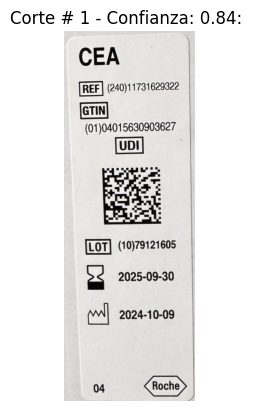

In [7]:

#Mostrar cada recorte detectado
mostrar_recortes(resultados)

## **Test 2:**

Doble Etiqueta (Descarte de etiqueta con baja calidad)

In [8]:
#RUTA: de la Imagen a procesar:
ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Label_Photos/Label_59.jpg"
#TAGS: Etiquetas que buscar:
etiquetas = ["REF", "LOT", "CADUCIDAD", "FABRICACION", "CANTIDAD"]


#PASO 1: Procesar la imagen
resultados = procesar_imagen_con_etiquetas(ruta, etiquetas)

#IMPRESION y GUARDADO: Mostrado de resultados
for res in resultados:
    print(f"\nCorte # {res['corte']} - Confianza: {res['confianza']:.2f}):")
    valores = res["valores"]

    for etiqueta, valor in res["valores"].items():
        print(f"{etiqueta}: {valor}")

    #PASO 2: Crear la fila del Dataframe
    fila = construir_fila_dataframe(ruta, valores)
    display(fila)  #Mostrar la tabla

    #PASO 3: Guardar en el CSV
    guardar_en_csv(fila)


0: 640x480 2 etiquetas, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
[Agregado] Corte #1 - Confianza: 0.88
[Descartado] Corte #2 - Confianza: 0.58

Corte # 1 - Confianza: 0.88):
REF: (240)11776223190
LOT: (10)82396601
CANTIDAD: NA
FABRICACION: 2024-09-03
CADUCIDAD: 2026-02-28


,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_59.jpg,2025-06-01 23:09:31,(240)11776223190,(10)82396601,2024-09-03,2026-02-28,NA


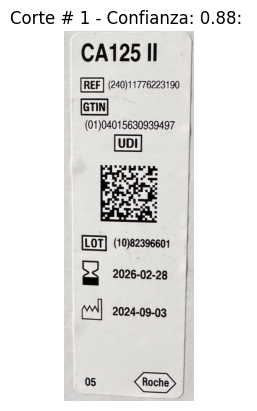

In [9]:

# Mostrar los recortes detectados
mostrar_recortes(resultados)

## **Test 3:**
Multiples Etiquetas en una sola imagen

In [10]:
#RUTA: de la Imagen a procesar:
ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Label_Photos/Label_98.JPG"
#TAGS: Etiquetas que buscar:
etiquetas = ["REF", "LOT", "CADUCIDAD", "FABRICACION", "CANTIDAD"]


#PASO 1: Procesar la imagen
resultados = procesar_imagen_con_etiquetas(ruta, etiquetas)

#IMPRESION y GUARDADO: Mostrado de resultados
for res in resultados:
    print(f"\nCorte # {res['corte']} - Confianza: {res['confianza']:.2f}):")
    valores = res["valores"]

    for etiqueta, valor in res["valores"].items():
        print(f"{etiqueta}: {valor}")

    #PASO 2: Crear la fila del Dataframe
    fila = construir_fila_dataframe(ruta, valores)
    display(fila)  #Mostrar la tabla

    #PASO 3: Guardar en el CSV
    guardar_en_csv(fila)


0: 640x480 2 etiquetas, 7.0ms
Speed: 3.6ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
[Agregado] Corte #1 - Confianza: 0.88
[Agregado] Corte #2 - Confianza: 0.81

Corte # 1 - Confianza: 0.88):
REF: (240103183971122
LOT: (10)79767101
CANTIDAD: NA
FABRICACION: 2024-07-11
CADUCIDAD: 2026-03-31


,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_98.JPG,2025-06-01 23:09:58,(240103183971122,(10)79767101,2024-07-11,2026-03-31,NA



Corte # 2 - Confianza: 0.81):
REF: (240)11776193122
LOT: (10)78239103
CANTIDAD: NA
FABRICACION: 2024-07-01
CADUCIDAD: 2025-10-31


,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_98.JPG,2025-06-01 23:09:58,(240)11776193122,(10)78239103,2024-07-01,2025-10-31,NA


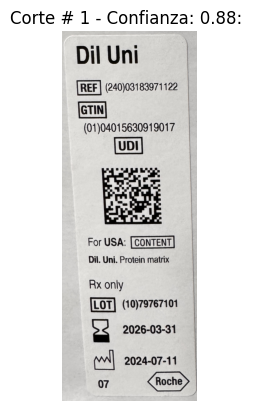

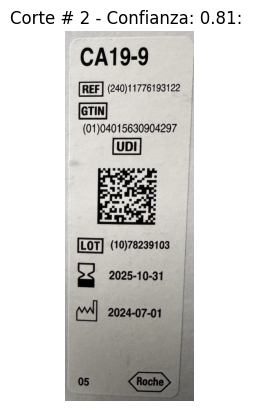

In [11]:
#Mostrar cada recorte detectado
mostrar_recortes(resultados)

### Visualizacion del CSV creado despues de los tres tests: ###




In [12]:
#Ruta al CSV
csv_ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/datos_etiquetas.csv"

#Mostrado del CSV mediante un dataframe:
df_csv = pd.read_csv(csv_ruta)
df_csv

,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_60.jpg,2025-06-01 23:04:26,(240)11731629322,(10)79121605,2024-10-09,2025-09-30,NaN
1,Label_59.jpg,2025-06-01 23:09:31,(240)11776223190,(10)82396601,2024-09-03,2026-02-28,NaN
2,Label_98.JPG,2025-06-01 23:09:58,(240103183971122,(10)79767101,2024-07-11,2026-03-31,NaN
3,Label_98.JPG,2025-06-01 23:09:58,(240)11776193122,(10)78239103,2024-07-01,2025-10-31,NaN
